# Libraries

## Points to note
- 1 is assigned as an anomaly and 0 is assigned as normal record

In [1061]:
import pandas as pd
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN,KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# Load the data
df = pd.read_csv("sales_data.csv")

# Standardization
# Columns to standardize
# columns_to_standardize = ['Units_Sold', 'Unit_Price', 'Total_Sales']
# scaler = StandardScaler()
# df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])
df.head()

,Date,Product_ID,Product_Name,Units_Sold,Unit_Price,Total_Sales,Actual_Anomaly
0,2024-07-05,1,Adapter,187,112.22,20985.14,0
1,2024-07-24,2,Television,66,728.23,48063.18,0
2,2024-07-08,3,iPhone,458,276.23,126513.34,0
3,2024-07-13,4,Macbook,14,675.81,9461.34,0
4,2024-07-24,5,Macbook,461,885.17,408063.37,0


# IQR - Single Feature

In [1062]:
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (df[column] < lower_bound) | (df[column] > upper_bound)
    return outliers

# Detect outliers in the 'Value' column
outliers = detect_outliers_iqr(df, 'Total_Sales')
df['IQRAnomaly'] = outliers
df['IQRAnomaly'] = df['IQRAnomaly'].apply(lambda x: 1 if x == True else 0)
IQR_SCORE=(df[df.IQRAnomaly==True].shape[0]/df[df.Actual_Anomaly==1].shape[0])*100
print("Accuracy Zscore : ",IQR_SCORE,"%")

Accuracy Zscore :  37.5 %


# Z-Score - Single Feature

In [1063]:
def detect_anomalies(data, threshold=.8):
    mean = np.mean(data)
    std_dev = np.std(data)
    z_scores = (data - mean) / std_dev
    anomalies = np.abs(z_scores) > threshold
    return z_scores, anomalies

# Calculate Z-Scores for Total_Sales
z_scores, anomalies = detect_anomalies(df['Total_Sales'])

# Add Z-Scores and Anomalies to the dataframe
df['Zscore'] = z_scores
df['ZscoreAnomaly'] = anomalies
df['ZscoreAnomaly'] = df['ZscoreAnomaly'].apply(lambda x: 1 if x == True else 0)
ZSCORE_SCORE=df[df.ZscoreAnomaly==True].shape[0]/df[df.Actual_Anomaly==1].shape[0]*100
print("Accuracy Zscore : ",ZSCORE_SCORE,"%")

Accuracy Zscore :  54.166666666666664 %


# Isolation Forest - Full Dataset

In [1064]:
# Only consider numerical data, We can convert the data into numerical categories using one hot encoding
clf = IsolationForest(n_estimators=100,max_samples='auto',contamination=float(0.25),random_state=np.random.RandomState(42))
df_if=df[['Product_ID', 'Units_Sold', 'Unit_Price','Total_Sales', 'Actual_Anomaly']]
clf.fit(df_if)
predictions=clf.predict(df_if)
df["IsoForAnomaly"] = predictions
df["IsoForAnomaly"] = df['IsoForAnomaly'].apply(lambda x: 1 if x == -1 else 0)
IF_SCORE=df[df.IsoForAnomaly==1].shape[0]/df[df.Actual_Anomaly==1].shape[0]*100
print("Accuracy Zscore : ",IF_SCORE,"%")

Accuracy Zscore :  79.16666666666666 %


# DBSCAN

In [1065]:

dbscan=DBSCAN(eps=0.1,min_samples=100)
dbscan.fit_predict(df_if)
df["DBSCANAnomaly"]=dbscan.labels_
df['DBSCANAnomaly']=df['DBSCANAnomaly'].apply(lambda x: 1 if x == -1 else 0)
DBSCAN_SCORE=df[df.DBSCANAnomaly==1].shape[0]/df[df.Actual_Anomaly==1].shape[0]*100
print("Accuracy Zscore : ",DBSCAN_SCORE,"%")

Accuracy Zscore :  316.66666666666663 %


# Local Factor Outlier - Whole Dataset

In [1066]:
#only use numeric columns
columns_to_use = df.select_dtypes(include=[np.number]).columns
X = df[columns_to_use]
# Initialize and fit the Local Outlier Factor model
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.25)
df['LFOFLAnomaly'] = lof.fit_predict(X)
df['LFOFLAnomaly'] = df['LFOFLAnomaly'].apply(lambda x: 1 if x == -1 else 0)
LOFWD_SCORE=df[df.LFOFLAnomaly==True].shape[0]/df[df.Actual_Anomaly==1].shape[0]*100
print("Accuracy Zscore : ",LOFWD_SCORE,"%")

Accuracy Zscore :  79.16666666666666 %


# Local Factor Outlier - Single Feature

In [1067]:
# Initialize and fit the Local Outlier Factor model
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.25)
df['LFOSFAnomaly'] = lof.fit_predict(df[["Total_Sales"]])
# LOF assigns -1 to anomalies and 1 to inliers
df['LFOSFAnomaly'] = df['LFOSFAnomaly'].apply(lambda x: 1 if x == -1 else 0)
LOFSF_SCORE=df[df.LFOSFAnomaly==True].shape[0]/df[df.Actual_Anomaly==1].shape[0]*100
print("Accuracy Zscore : ",LOFSF_SCORE,"%")

Accuracy Zscore :  79.16666666666666 %


# Missing Data KNN

Anomalies detected :
          Date  Entries  anomaly
7   2024-07-09        8     True
10  2024-07-13        6     True


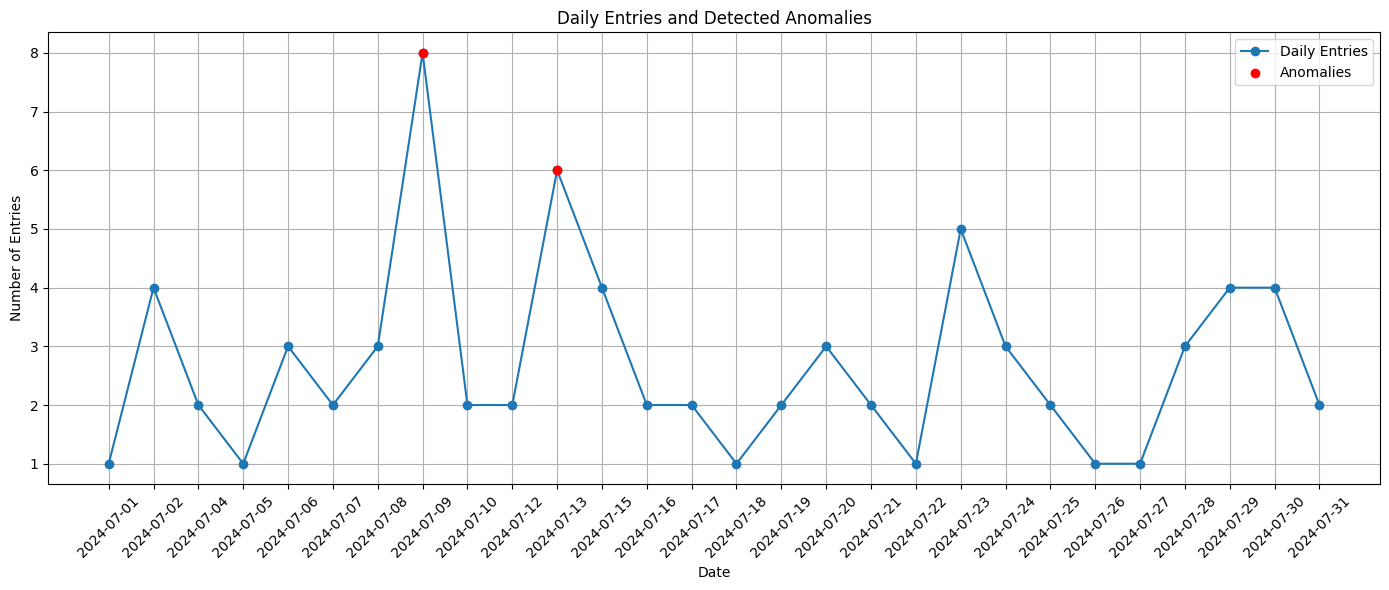

0.2

In [1068]:
# Aggregate the number of entries per day
daily_entries = df.groupby('Date').size().reset_index(name='Entries')

# Prepare the data for KNN
X = np.array(daily_entries['Entries']).reshape(-1, 1)

# Initialize and fit the KNN model
knn = NearestNeighbors(n_neighbors=5)
knn.fit(X)

# Calculate the distance to the nearest neighbors
distances, _ = knn.kneighbors(X)

# Calculate the mean distance to the k nearest neighbors
mean_distances = distances.mean(axis=1)

# Define an anomaly as a point with a mean distance greater than a threshold
threshold = mean_distances.mean() + 2 * mean_distances.std() # Akash suggestion - Draw  -  reference Line +- std
daily_entries['anomaly'] = mean_distances > threshold

# Filter the anomalies
anomalies = daily_entries[daily_entries['anomaly']]

print("Anomalies detected :")
print(anomalies[['Date', 'Entries', 'anomaly']])

plt.figure(figsize=(14, 6))
plt.plot(daily_entries['Date'], daily_entries['Entries'], label='Daily Entries', marker='o', linestyle='-')
plt.scatter(anomalies['Date'], anomalies['Entries'], color='red', label='Anomalies', zorder=5)
# plt.axhline(y = threshold, color = 'r', linestyle = '-') # Threshold Line
plt.xlabel('Date')
plt.ylabel('Number of Entries')
plt.title('Daily Entries and Detected Anomalies')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
distances.mean(axis=1).mean()

# MISSING DATA - KMEANS

In [1069]:
# df["Date"]=pd.to_datetime(df["Date"])
# df["Day"]=df.Date.dt.day
# df_kmeans=df[['Units_Sold', 'Unit_Price', 'Total_Sales', 'Actual_Anomaly','Day']]
# # Fit the K-means model
# kmeans = KMeans(n_clusters=3, random_state=0)
# kmeans.fit(df_kmeans)
# df["kmeans_cluster"]=kmeans.labels_
# # df[df.Actual_Anomaly==1]

In [1070]:
# daily_entries = df.groupby(df['Date'].dt.date).size().reset_index(name='Entries')
# # Prepare the data for K-means
# X = np.array(daily_entries['Entries']).reshape(-1, 1)

# # Fit the K-means model
# kmeans = KMeans(n_clusters=3, random_state=0)
# kmeans.fit(X)

# # Calculate distances to cluster centers
# distances = kmeans.transform(X)
# daily_entries['Distance_to_Center'] = np.min(distances, axis=1)

# # Define an anomaly as a point with a distance greater than a threshold
# threshold = daily_entries['Distance_to_Center'].mean() + 2 * daily_entries['Distance_to_Center'].std()
# daily_entries['anomaly'] = daily_entries['Distance_to_Center'] > threshold

# # Filter the anomalies
# anomalies_kmeans = daily_entries[daily_entries['anomaly']]
# anomalies_kmeans

# Summary

In [1071]:
# Create Summary Dataframe
summary_dictionary={
    "INTERQUARTILERANGE":[round(IQR_SCORE,2)],
    "ZSCORE":[round(ZSCORE_SCORE,2)],
    "ISOLATIONFOREST":[round(IF_SCORE,2)],
    "DBSCAN":[round(DBSCAN_SCORE,2)],
    "LOCALOUTLIERFACTORWD":[round(LOFWD_SCORE,2)],
    "LOCALOUTLIERFACTORSF":[round(LOFSF_SCORE,2)],
    "KNN_MISSINGDATA":str(list(anomalies["Date"]))
    }
scorecard=pd.DataFrame(summary_dictionary).T
scorecard.columns=["SCORECARD %"]
scorecard

,SCORECARD %
INTERQUARTILERANGE,37.5
ZSCORE,54.17
ISOLATIONFOREST,79.17
DBSCAN,316.67
LOCALOUTLIERFACTORWD,79.17
LOCALOUTLIERFACTORSF,79.17
KNN_MISSINGDATA,"['2024-07-09', '2024-07-13']"


In [1072]:
df.head()

,Date,Product_ID,Product_Name,Units_Sold,Unit_Price,Total_Sales,Actual_Anomaly,IQRAnomaly,Zscore,ZscoreAnomaly,IsoForAnomaly,DBSCANAnomaly,LFOFLAnomaly,LFOSFAnomaly
0,2024-07-05,1,Adapter,187,112.22,20985.14,0,0,-0.530669,0,0,1,0,0
1,2024-07-24,2,Television,66,728.23,48063.18,0,0,-0.529231,0,0,1,0,0
2,2024-07-08,3,iPhone,458,276.23,126513.34,0,0,-0.525067,0,0,1,0,0
3,2024-07-13,4,Macbook,14,675.81,9461.34,0,0,-0.531280,0,0,1,0,0
4,2024-07-24,5,Macbook,461,885.17,408063.37,0,0,-0.510121,0,0,1,0,0
